# Real(1k,4k) VS Biased generated(45k)*italicized text*

In [1]:
%%capture 
!pip install ipython-autotime

%load_ext autotime
%matplotlib inline

time: 2.4 ms (started: 2023-03-08 13:27:56 +00:00)


In [2]:
%matplotlib inline
import torch
torch.manual_seed(42)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.sampler import Sampler
import numpy as np
np.random.seed(0)
import random
random.seed(10)
import matplotlib.pyplot as plt
import os
import copy


time: 2.26 s (started: 2023-03-08 13:27:56 +00:00)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# read a file 3.0 gb
os.chdir("/content/gdrive/My Drive/prachi deepak_sharedFolder/bias-correction-generative")

Mounted at /content/gdrive
time: 33.8 s (started: 2023-03-08 13:28:00 +00:00)


In [4]:
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

time: 654 ms (started: 2023-03-08 13:28:34 +00:00)


In [5]:
gpu_info = !nvidia-smi -L
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-c9c2f20d-6dfe-6753-b22a-ee9c5d352c01)
Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
time: 1.55 s (started: 2023-03-08 13:28:34 +00:00)


In [ ]:
# xtrva_gen1 = np.load('./samples/vae/gen_samples.npz')
# xtrva_gen1 = torch.from_numpy(xtrva_gen1['train_data'].astype('float64').transpose((0,3,1,2)))
# xtrva_gen1[:42000].shape

torch.Size([42000, 3, 32, 32])

time: 614 ms (started: 2023-03-07 01:38:09 +00:00)


is 400 samples per class 4000


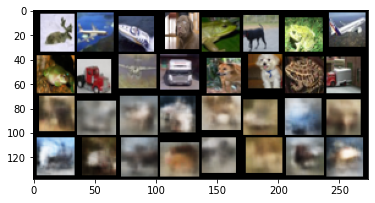

time: 45.8 s (started: 2023-03-07 01:43:25 +00:00)


In [ ]:
# semi supervised: cifar + generated samples
# entire dataset of 95k

# right cifar10 data + applied trans_normalization + tensor images
t = transforms.Compose(
    [transforms.ToTensor()])
tt = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    # transforms.ToTensor()
    ])
xtrva_real1 = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=t)
real_labels = [y for _,y in xtrva_real1]
# s(xtrva_real[0][0])
# plt.show()
# loading biased samples
xtrva_gen1 = np.load('./samples/vae/gen_samples.npz')
xtrva_gen1 = torch.from_numpy(xtrva_gen1['train_data'].astype('float64').transpose((0,3,1,2)))
class myEntireDataset(Dataset):
    #return tuples
    def __init__(self,xy_real, xy_gen):
        # xy_real = TensorDataset(xy_real, torch.tensor(real_labels) ) # tensor, dense labels, should not be a tuple, therefore processing outside the class
        xy_gen = TensorDataset(xy_gen, torch.full(([len(xy_gen)]),-1)) # tensor, tuples
        
        self.xy = ConcatDataset([xy_real, xy_gen])

        uniqe_labels = np.append(np.arange(10), -1)
        self.indices = [[] for _ in range(11)]
        for i, (img,label) in enumerate(self.xy):
            for label_ in uniqe_labels:
                if label == label_:
                    self.indices[label_].append(i) 

    def __len__(self):
        return len(self.xy)

    def classes(self):
        return self.indices

    def __getitem__(self, idx):
        x,y = self.xy[idx]
        x = tt(x)
        return x,y

class Sampler():
    # [[1,2,3],[50000,50001]]
    def __init__(self, classes, bs, n_labelled):
        self.classes = classes
        self.bs = bs
        self.n_labelled = n_labelled

    def __iter__(self):
        classes = copy.deepcopy(self.classes)
        # indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50000,50001,50002,50003,50004,50005,50006,50007,50008,50009,50010,50011,50012,50013,50014,50015,50016]
        # reandom class 1 [[29, 30, 35, 49, 77, 93, 115, 11],[]]
        # print(classes)
        indices = []
        # for i in range(11):
        #     indices.append(sample(train.classes()[i],10))


        labeled_data = classes[:-1]
        unlabeled_data = classes[-1]
        # # how many wants from each class
        indices_from_each_class = self.n_labelled // (len(classes)-1)
        final_data = []
        for i,eachClassLst in enumerate(labeled_data):
            final_data.append(random.sample(eachClassLst,indices_from_each_class))

        # flatten final data
        final_data = [item for sublist in final_data for item in sublist]
        print(f'is {indices_from_each_class} samples per class {len(final_data)}')
        # del final_data

        ffinal_data = []
        h = int(0.5*self.bs)
        # iterations over one epoch
        for i in range(50000//self.bs):
            c = []
            c[:h] = random.sample(final_data,h)
            # print('first_half',c)
            # without replacements in each batch BUT with replacement across batches
            c[h:self.bs] = random.sample(unlabeled_data,h)
            ffinal_data.append(c)
            del c
                
        # print(ffinal_data)
        return iter(ffinal_data)

        



train123 = myEntireDataset(xtrva_real1, xtrva_gen1[:42000])
dl2 = torch.utils.data.DataLoader(train123, batch_sampler = Sampler(train123.classes(),32,4000))

# get some random training images
dataiter = iter(dl2)
images, labels = next(dataiter)
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
dataiter = iter(dl2)
images, labels = next(dataiter)


is 100 samples per class 1000
time: 388 ms (started: 2023-03-01 04:23:09 +00:00)


In [ ]:
len(train123)

95000

time: 705 ms (started: 2023-03-03 04:05:09 +00:00)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F


def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# net = ResNet(ResidualBlock, [2, 2, 2]).to(device)




# net = Net()


time: 6.59 ms (started: 2023-03-08 13:28:46 +00:00)


In [7]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

time: 415 µs (started: 2023-03-08 13:28:50 +00:00)


In [8]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
# imshow(torchvision.utils.make_grid(images))

time: 637 µs (started: 2023-03-08 13:28:51 +00:00)


Files already downloaded and verified


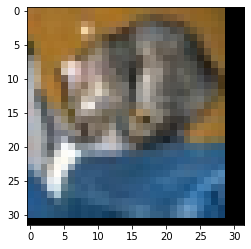

time: 12 s (started: 2023-03-08 13:28:52 +00:00)


In [9]:
trans = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
    ])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=trans)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
imshow(testset[0][0])

In [10]:
def one_hot_labels(labels, num_classes=10):
    num_labels = labels.shape[0]
    labels_one_hot = np.zeros((num_labels, num_classes))
    for i,label in enumerate(labels):
        if label==-1:
            continue
        else:
            (labels_one_hot[i]).put(label,1)
    return torch.tensor(labels_one_hot)

def wmc(y_logits):
    normalized_logits = nn.Sigmoid()(y_logits)
    wmc_tmp = torch.zeros([batch_size,]).to(device) # 32
    for i in range(10):
        one_situation = torch.concat(
            [torch.concat([torch.ones([batch_size,i]), torch.zeros([batch_size,1])],axis=1),
             torch.ones([batch_size, 10-i-1])], axis=1
        )
        # print('here', one_situation.shape, normalized_logits.shape, wmc_tmp.shape) # torch.Size([32, 10]) torch.Size([32, 10]) torch.Size([32])
        wmc_tmp += torch.prod(one_situation.to(device) - normalized_logits, axis=1) #torch.Size([32])
    wmc_tmp = torch.abs(wmc_tmp)
    # wmc = torch.mean(wmc_temp)
    return wmc_tmp

def criterion(y_logits, y_true):
    # ce = torch.sum(nn.Cross EntropyLoss()(y_logits,y_true))
    ce = torch.sum(nn.functional.binary_cross_entropy_with_logits(y_logits,y_true,reduction='none'),axis=1)
    # print('here')
    # labeled ex
    wmc_tmp = wmc(y_logits)
    # unlabeled ex
    # print('here-->',torch.max(y_true, axis=1).values, )
    # print(torch.zeros([batch_size,]).to(device))
    # print(torch.gt(torch.max(y_true, axis=1).values, torch.zeros([batch_size,]).to(device)).type(torch.DoubleTensor))
    label_examples = torch.gt(torch.max(y_true, axis=1).values, torch.zeros([batch_size,]).to(device)).type(torch.DoubleTensor).to(device)
    unlabel_examples = torch.ones([batch_size,]).to(device) - label_examples
    log_wmc = torch.log(wmc_tmp)

    loss = -0.0005*torch.mul(unlabel_examples, log_wmc) - 0.0005*torch.mul(label_examples,log_wmc)+torch.mul(label_examples,ce)

    loss = torch.mean(loss)
    return loss,label_examples

time: 3.41 ms (started: 2023-03-08 13:29:15 +00:00)


In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
for i in range(3):
    print(f'--------{i}-------')
    net = ResNet(ResidualBlock, [2, 2, 2])
    for param in net.parameters():
        print(param[0])
    print(f'---------{i+1}------')

## 1k_SAMPLES

-->starting first experiment_1/10
---->staring epoch_1/20 epoch
is 100 samples per class 1000
 train_0 acc --> correct: 9470.0, total_labeled: 24992.0, Accuracy: 37.89212548015365 %
test_0 acc --> correct: 3872.0, total_labeled: 10000, Accuracy: 38.72%
---->staring epoch_2/20 epoch
is 100 samples per class 1000
 train_1 acc --> correct: 13935.0, total_labeled: 24992.0, Accuracy: 55.75784250960307 %
test_1 acc --> correct: 4462.0, total_labeled: 10000, Accuracy: 44.62%
---->staring epoch_3/20 epoch
is 100 samples per class 1000
 train_2 acc --> correct: 15044.0, total_labeled: 24992.0, Accuracy: 60.19526248399488 %
test_2 acc --> correct: 4967.0, total_labeled: 10000, Accuracy: 49.67%
---->staring epoch_4/20 epoch
is 100 samples per class 1000
 train_3 acc --> correct: 16674.0, total_labeled: 24992.0, Accuracy: 66.7173495518566 %
test_3 acc --> correct: 5189.0, total_labeled: 10000, Accuracy: 51.89%
---->staring epoch_5/20 epoch
is 100 samples per class 1000
 train_4 acc --> correct: 17

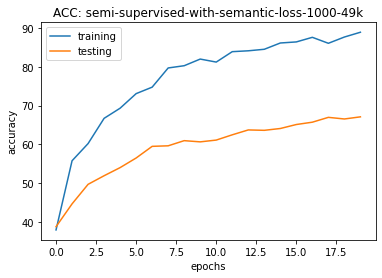

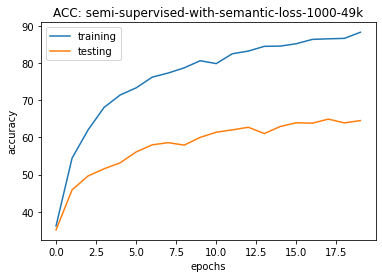

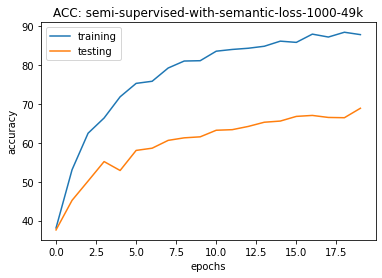

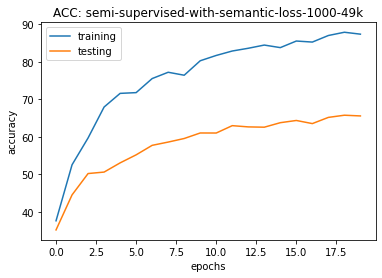

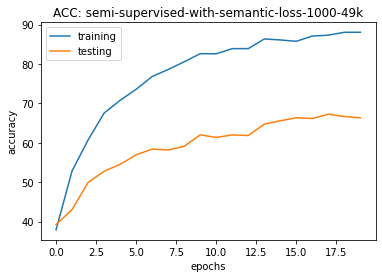

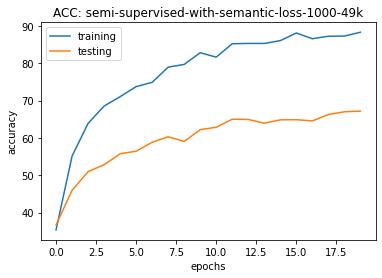

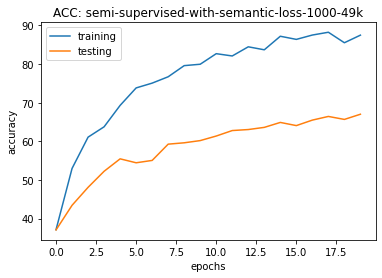

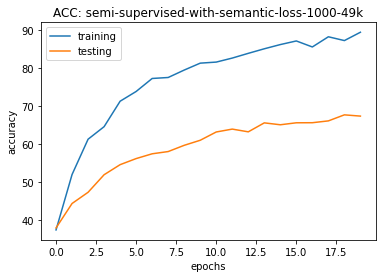

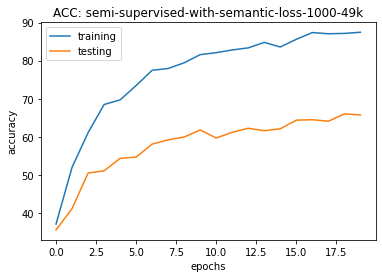

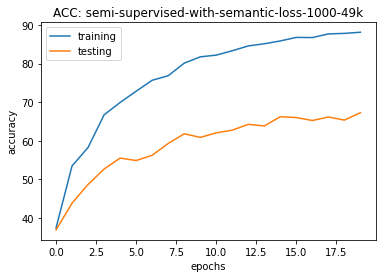

time: 2h 23min 34s (started: 2023-03-02 03:45:05 +00:00)


In [ ]:
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    print('Finished Training')
    plt.figure()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: semi-supervised-with-semantic-loss-1000-49k')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(f'./new_run_{run}_for_all_epochs.png')

--------------------------------------------------------
-->starting experiment_1/10
---->staring epoch_1/20 epoch
is 100 samples per class 1000
 train_0 acc --> correct: 9683.0, total_labeled: 24992.0, Accuracy: 38.74439820742638 %
test_0 acc --> correct: 3942.0, total_labeled: 10000, Accuracy: 39.42%
---->staring epoch_2/20 epoch
is 100 samples per class 1000
 train_1 acc --> correct: 13357.0, total_labeled: 24992.0, Accuracy: 53.44510243277849 %
test_1 acc --> correct: 4856.0, total_labeled: 10000, Accuracy: 48.56%
---->staring epoch_3/20 epoch
is 100 samples per class 1000
 train_2 acc --> correct: 15756.0, total_labeled: 24992.0, Accuracy: 63.04417413572343 %
test_2 acc --> correct: 5182.0, total_labeled: 10000, Accuracy: 51.82%
---->staring epoch_4/20 epoch
is 100 samples per class 1000
 train_3 acc --> correct: 17236.0, total_labeled: 24992.0, Accuracy: 68.96606914212548 %
test_3 acc --> correct: 5523.0, total_labeled: 10000, Accuracy: 55.23%
---->staring epoch_5/20 epoch
is 100

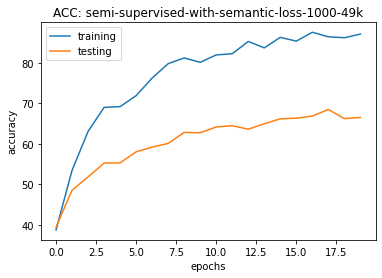

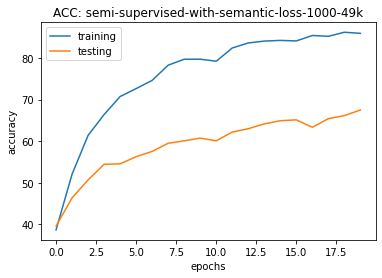

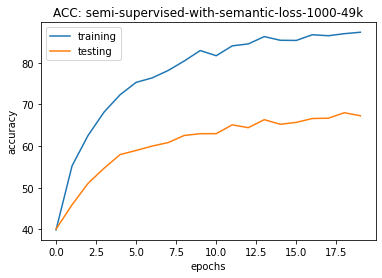

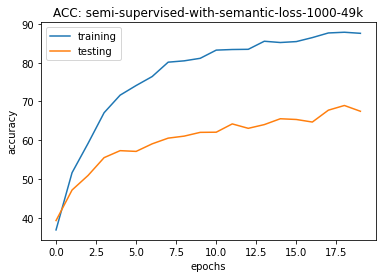

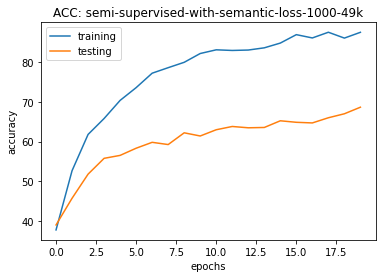

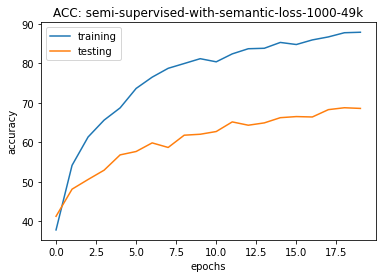

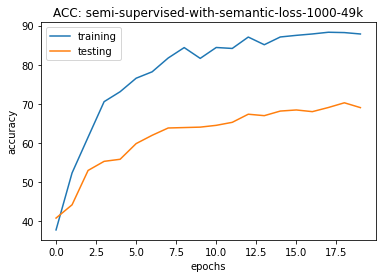

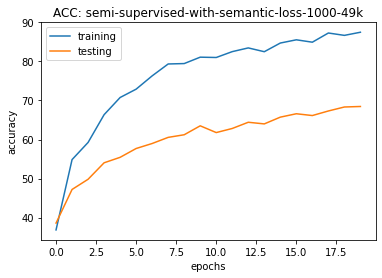

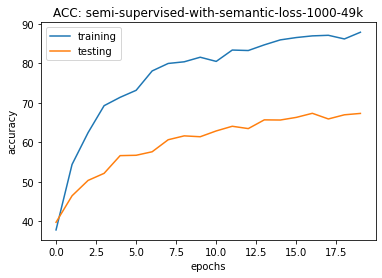

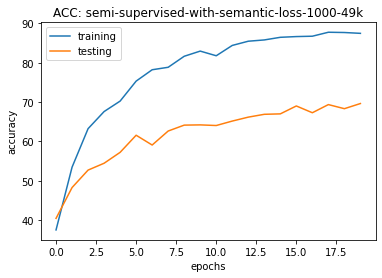

time: 2h 19min 25s (started: 2023-03-03 04:11:49 +00:00)


In [ ]:
#pixelcnn++, 1000
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    with open('./evaluation_task/all_test_acc.txt','a') as f:
        for key, value in all_testing_acc.items(): 
            f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    plt.figure()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: semi-supervised-with-semantic-loss-1000-49k')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(f'./new_run_{run}_for_all_epochs.png')

In [ ]:
!kill -9 -1

## 4k_SAMPLES

### 4000_vae_SAMPLES

is 400 samples per class 4000


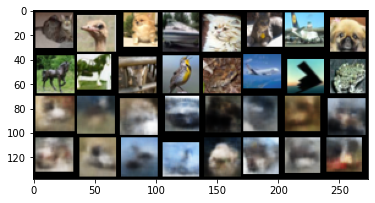

time: 37.5 s (started: 2023-03-07 02:00:10 +00:00)


In [ ]:
# semi supervised: cifar + generated samples
# entire dataset of 95k

# right cifar10 data + applied trans_normalization + tensor images
t = transforms.Compose(
    [transforms.ToTensor()])
tt = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    # transforms.ToTensor()
    ])
xtrva_real1 = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=t)
real_labels = [y for _,y in xtrva_real1]
# s(xtrva_real[0][0])
# plt.show()
# loading biased samples
xtrva_gen1 = np.load('./samples/vae/gen_samples.npz')
xtrva_gen1 = torch.from_numpy(xtrva_gen1['train_data'].astype('float64').transpose((0,3,1,2)))
class myEntireDataset(Dataset):
    #return tuples
    def __init__(self,xy_real, xy_gen):
        # xy_real = TensorDataset(xy_real, torch.tensor(real_labels) ) # tensor, dense labels, should not be a tuple, therefore processing outside the class
        xy_gen = TensorDataset(xy_gen, torch.full(([len(xy_gen)]),-1)) # tensor, tuples
        
        self.xy = ConcatDataset([xy_real, xy_gen])

        uniqe_labels = np.append(np.arange(10), -1)
        self.indices = [[] for _ in range(11)]
        for i, (img,label) in enumerate(self.xy):
            for label_ in uniqe_labels:
                if label == label_:
                    self.indices[label_].append(i) 

    def __len__(self):
        return len(self.xy)

    def classes(self):
        return self.indices

    def __getitem__(self, idx):
        x,y = self.xy[idx]
        x = tt(x)
        return x,y

class Sampler():
    # [[1,2,3],[50000,50001]]
    def __init__(self, classes, bs, n_labelled):
        self.classes = classes
        self.bs = bs
        self.n_labelled = n_labelled

    def __iter__(self):
        classes = copy.deepcopy(self.classes)
        # indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50000,50001,50002,50003,50004,50005,50006,50007,50008,50009,50010,50011,50012,50013,50014,50015,50016]
        # reandom class 1 [[29, 30, 35, 49, 77, 93, 115, 11],[]]
        # print(classes)
        indices = []
        # for i in range(11):
        #     indices.append(sample(train.classes()[i],10))

        labeled_data = classes[:-1]
        unlabeled_data = classes[-1]
        # # how many wants from each class
        indices_from_each_class = self.n_labelled // (len(classes)-1)
        final_data = []
        for i,eachClassLst in enumerate(labeled_data):
            final_data.append(random.sample(eachClassLst,indices_from_each_class))

        # flatten final data
        final_data = [item for sublist in final_data for item in sublist]
        print(f'is {indices_from_each_class} samples per class {len(final_data)}')
        # del final_data
        # print('total real samples',len(final_data))

        ffinal_data = []
        h = int(0.5*self.bs)
        # iterations over one epoch
        for i in range(50000//self.bs):
            c = []
            c[:h] = random.sample(final_data,h)
            # print('first_half',c)
            # without replacements in each batch BUT with replacement across batches
            c[h:self.bs] = random.sample(unlabeled_data,h)
            ffinal_data.append(c)
            del c
                
        # print(ffinal_data)
        return iter(ffinal_data)

        
train123 = myEntireDataset(xtrva_real1, xtrva_gen1[:42000])
dl2 = torch.utils.data.DataLoader(train123, batch_sampler = Sampler(train123.classes(),32,4000))

# get some random training images
dataiter = iter(dl2)
images, labels = next(dataiter)
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(images))



--------------------------------------------------------
-->starting experiment_1/10
---->staring epoch_1/20 epoch
is 400 samples per class 4000
 train_0 acc --> correct: 8107.0, total_labeled: 24992.0, Accuracy: 32.438380281690144 %
test_0 acc --> correct: 3825.0, total_labeled: 10000, Accuracy: 38.25%
---->staring epoch_2/20 epoch
is 400 samples per class 4000
 train_1 acc --> correct: 11826.0, total_labeled: 24992.0, Accuracy: 47.319142125480155 %
test_1 acc --> correct: 4536.0, total_labeled: 10000, Accuracy: 45.36%
---->staring epoch_3/20 epoch
is 400 samples per class 4000
 train_2 acc --> correct: 13743.0, total_labeled: 24992.0, Accuracy: 54.9895966709347 %
test_2 acc --> correct: 5217.0, total_labeled: 10000, Accuracy: 52.17%
---->staring epoch_4/20 epoch
is 400 samples per class 4000
 train_3 acc --> correct: 14673.0, total_labeled: 24992.0, Accuracy: 58.710787451984636 %
test_3 acc --> correct: 5621.0, total_labeled: 10000, Accuracy: 56.21%
---->staring epoch_5/20 epoch
is 4

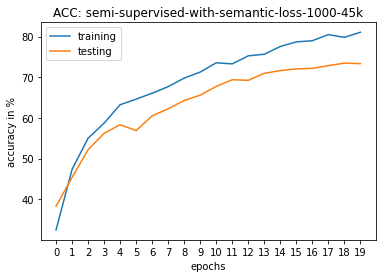

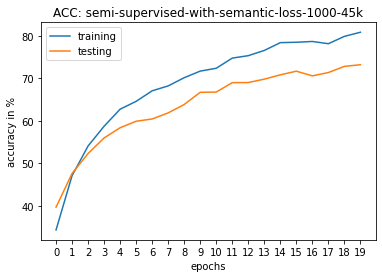

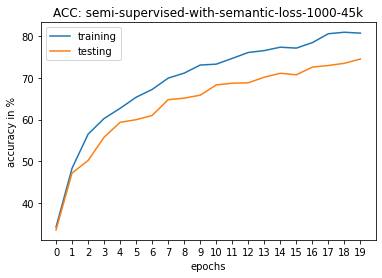

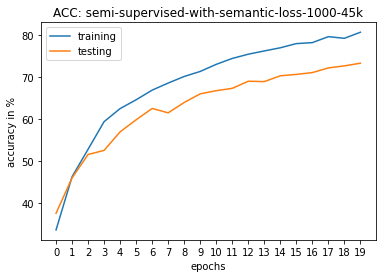

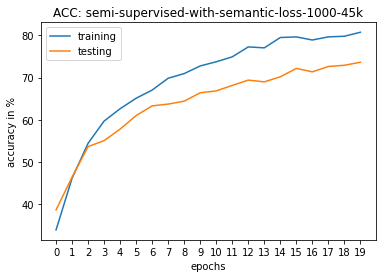

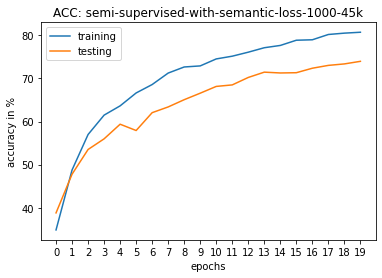

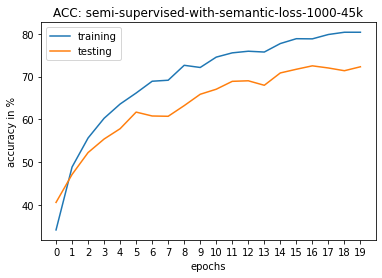

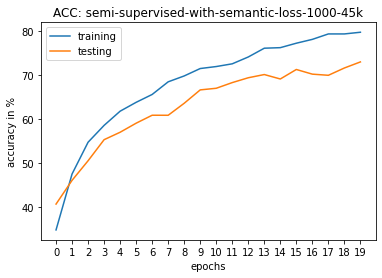

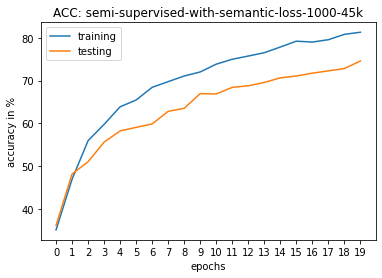

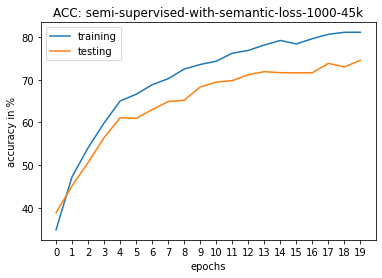

time: 2h 22min 14s (started: 2023-03-07 02:00:54 +00:00)


In [ ]:
# this accuracy is for reapeating same resampled image in dataset and dataloader, repeated indices_j
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    
    with open('./evaluation_task/vae_4k_samples/test_acc.txt','a') as f:
        for key, value in all_testing_acc.items(): 
            f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    plt.figure()
    ax = plt.axes()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: semi-supervised-with-semantic-loss-1000-45k')
    ax.set_xticks(np.arange(max_epochs))
    plt.xlabel('epochs')
    plt.ylabel('accuracy in %')
    plt.legend()
    plt.savefig(f'./evaluation_task/vae_4k_samples/new_run_{run}_for_all_epochs.png')

### 4000_pp_SAMPLES

is 400 samples per class 4000


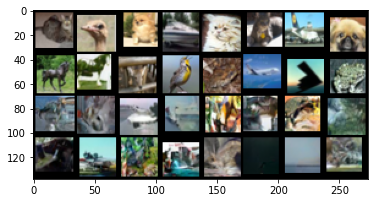

time: 26.9 s (started: 2023-03-07 16:06:55 +00:00)


In [ ]:
#pixelcnnpp 4k
# semi supervised: cifar + generated samples
# entire dataset of 95k

# right cifar10 data + applied trans_normalization + tensor images
t = transforms.Compose(
    [transforms.ToTensor()])
tt = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    # transforms.ToTensor()
    ])
xtrva_real1 = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=t)
real_labels = [y for _,y in xtrva_real1]
# s(xtrva_real[0][0])
# plt.show()
# loading biased samples
xtrva_gen1 = np.load('./samples/pixelcnnpp/gen_samples.npz')
xtrva_gen1 = torch.from_numpy(xtrva_gen1['train_data'].astype('float64').transpose((0,3,1,2)))
class myEntireDataset(Dataset):
    #return tuples
    def __init__(self,xy_real, xy_gen):
        # xy_real = TensorDataset(xy_real, torch.tensor(real_labels) ) # tensor, dense labels, should not be a tuple, therefore processing outside the class
        xy_gen = TensorDataset(xy_gen, torch.full(([len(xy_gen)]),-1)) # tensor, tuples
        
        self.xy = ConcatDataset([xy_real, xy_gen])

        uniqe_labels = np.append(np.arange(10), -1)
        self.indices = [[] for _ in range(11)]
        for i, (img,label) in enumerate(self.xy):
            for label_ in uniqe_labels:
                if label == label_:
                    self.indices[label_].append(i) 

    def __len__(self):
        return len(self.xy)

    def classes(self):
        return self.indices

    def __getitem__(self, idx):
        x,y = self.xy[idx]
        x = tt(x)
        return x,y

class Sampler():
    # [[1,2,3],[50000,50001]]
    def __init__(self, classes, bs, n_labelled):
        self.classes = classes
        self.bs = bs
        self.n_labelled = n_labelled

    def __iter__(self):
        classes = copy.deepcopy(self.classes)
        # indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50000,50001,50002,50003,50004,50005,50006,50007,50008,50009,50010,50011,50012,50013,50014,50015,50016]
        # reandom class 1 [[29, 30, 35, 49, 77, 93, 115, 11],[]]
        # print(classes)
        indices = []
        # for i in range(11):
        #     indices.append(sample(train.classes()[i],10))

        labeled_data = classes[:-1]
        unlabeled_data = classes[-1]
        # # how many wants from each class
        indices_from_each_class = self.n_labelled // (len(classes)-1)
        final_data = []
        for i,eachClassLst in enumerate(labeled_data):
            final_data.append(random.sample(eachClassLst,indices_from_each_class))

        # flatten final data
        final_data = [item for sublist in final_data for item in sublist]
        print(f'is {indices_from_each_class} samples per class {len(final_data)}')
        # del final_data
        # print('total real samples',len(final_data))

        ffinal_data = []
        h = int(0.5*self.bs)
        # iterations over one epoch
        for i in range(50000//self.bs):
            c = []
            c[:h] = random.sample(final_data,h)
            # print('first_half',c)
            # without replacements in each batch BUT with replacement across batches
            c[h:self.bs] = random.sample(unlabeled_data,h)
            ffinal_data.append(c)
            del c
                
        # print(ffinal_data)
        return iter(ffinal_data)

        
train123 = myEntireDataset(xtrva_real1, xtrva_gen1[:42000])
dl2 = torch.utils.data.DataLoader(train123, batch_sampler = Sampler(train123.classes(),32,4000))

# get some random training images
dataiter = iter(dl2)
images, labels = next(dataiter)
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(images))



--------------------------------------------------------
-->starting experiment_1/10
---->staring epoch_1/20 epoch
is 400 samples per class 4000
 train_0 acc --> correct: 8006.0, total_labeled: 24992.0, Accuracy: 32.0342509603073 %
test_0 acc --> correct: 4086.0, total_labeled: 10000, Accuracy: 40.86%
---->staring epoch_2/20 epoch
is 400 samples per class 4000
 train_1 acc --> correct: 11956.0, total_labeled: 24992.0, Accuracy: 47.8393085787452 %
test_1 acc --> correct: 4942.0, total_labeled: 10000, Accuracy: 49.42%
---->staring epoch_3/20 epoch
is 400 samples per class 4000
 train_2 acc --> correct: 13672.0, total_labeled: 24992.0, Accuracy: 54.70550576184379 %
test_2 acc --> correct: 5513.0, total_labeled: 10000, Accuracy: 55.13%
---->staring epoch_4/20 epoch
is 400 samples per class 4000
 train_3 acc --> correct: 14837.0, total_labeled: 24992.0, Accuracy: 59.36699743918054 %
test_3 acc --> correct: 5883.0, total_labeled: 10000, Accuracy: 58.83%
---->staring epoch_5/20 epoch
is 400 s

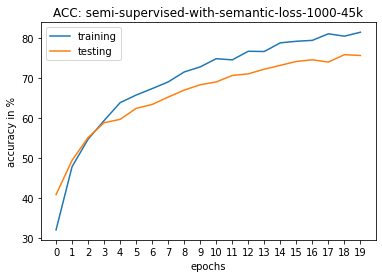

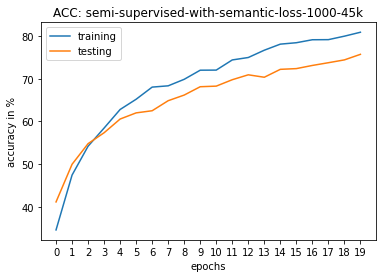

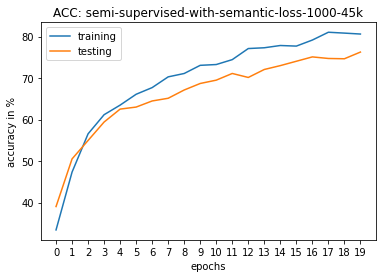

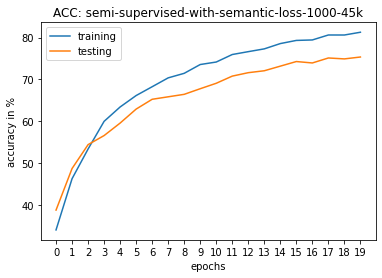

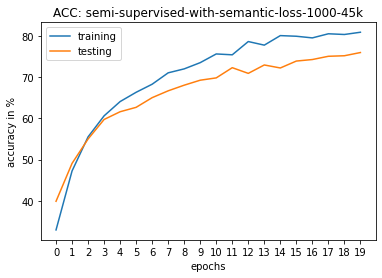

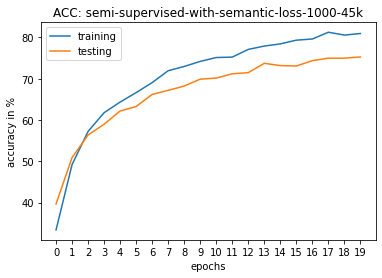

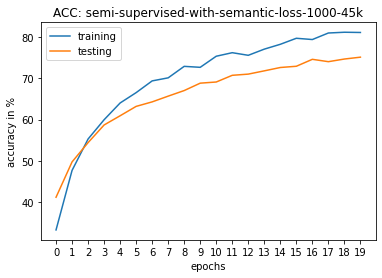

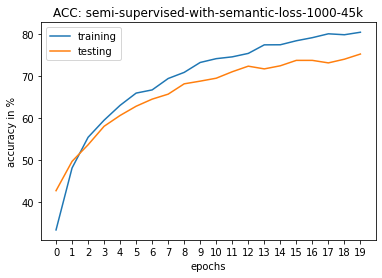

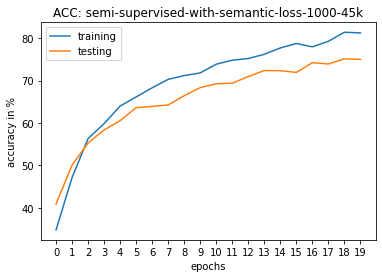

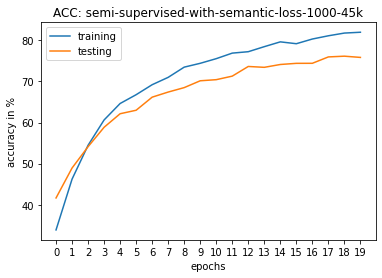

time: 2h 20min 19s (started: 2023-03-07 16:34:42 +00:00)


In [ ]:
# this accuracy is for reapeating same resampled image in dataset and dataloader, repeated indices_j
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    
    with open('./evaluation_task/pixelcnnpp_4k_samples/test_acc.txt','a') as f:
        for key, value in all_testing_acc.items(): 
            f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    plt.figure()
    ax = plt.axes()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: semi-supervised-with-semantic-loss-1000-45k')
    ax.set_xticks(np.arange(max_epochs))
    plt.xlabel('epochs')
    plt.ylabel('accuracy in %')
    plt.legend()
    plt.savefig(f'./evaluation_task/pixelcnnpp_4k_samples/new_run_{run}_for_all_epochs.png')

## 4k_RESAMPLES

### vae

is 400 samples per class 4000


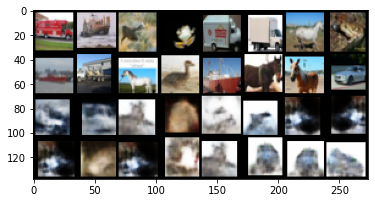

time: 23 s (started: 2023-03-07 19:54:50 +00:00)


In [ ]:
# semi supervised: cifar + generated samples
# entire dataset of 95k

# right cifar10 data + applied trans_normalization + tensor images
t = transforms.Compose(
    [transforms.ToTensor()])
tt = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    # transforms.ToTensor()
    ])
xtrva_real1 = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=t)
real_labels = [y for _,y in xtrva_real1]
# s(xtrva_real[0][0])
# plt.show()
# loading biased samples
xtrva_gen1 = np.load('./resamples/resamples_vae_45k.npz')
xtrva_gen1 = torch.from_numpy(xtrva_gen1['resample'].astype('float64').transpose((0,3,1,2)))

class myEntireDataset(Dataset):
    #return tuples
    def __init__(self,xy_real, xy_gen):
        # xy_real = TensorDataset(xy_real, torch.tensor(real_labels) ) # tensor, dense labels, should not be a tuple, therefore processing outside the class
        xy_gen = TensorDataset(xy_gen, torch.full(([len(xy_gen)]),-1)) # tensor, tuples
        
        self.xy = ConcatDataset([xy_real, xy_gen])

        uniqe_labels = np.append(np.arange(10), -1)
        self.indices = [[] for _ in range(11)]
        for i, (img,label) in enumerate(self.xy):
            for label_ in uniqe_labels:
                if label == label_:
                    self.indices[label_].append(i) 

    def __len__(self):
        return len(self.xy)

    def classes(self):
        return self.indices

    def __getitem__(self, idx):
        x,y = self.xy[idx]
        x = tt(x)
        return x,y

class Sampler():
    # [[1,2,3],[50000,50001]]
    def __init__(self, classes, bs, n_labelled):
        self.classes = classes
        self.bs = bs
        self.n_labelled = n_labelled

    def __iter__(self):
        classes = copy.deepcopy(self.classes)
        # indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50000,50001,50002,50003,50004,50005,50006,50007,50008,50009,50010,50011,50012,50013,50014,50015,50016]
        # reandom class 1 [[29, 30, 35, 49, 77, 93, 115, 11],[]]
        # print(classes)
        indices = []
        # for i in range(11):
        #     indices.append(sample(train.classes()[i],10))


        labeled_data = classes[:-1]
        unlabeled_data = classes[-1]
        # # how many wants from each class
        indices_from_each_class = self.n_labelled // (len(classes)-1)
        final_data = []
        for i,eachClassLst in enumerate(labeled_data):
            final_data.append(random.sample(eachClassLst,indices_from_each_class))
      
        # flatten final data
        final_data = [item for sublist in final_data for item in sublist]
        print(f'is {indices_from_each_class} samples per class {len(final_data)}')
        # del final_data
        # print('total labeled data hould be 4k',len(final_data))
        ffinal_data = []
        h = int(0.5*self.bs)
        # iterations over one epoch
        for i in range(50000//self.bs):
            c = []
            c[:h] = random.sample(final_data,h)
            # print('first_half',c)
            # without replacements in each batch BUT with replacement across batches
            c[h:self.bs] = random.sample(unlabeled_data,h)
            ffinal_data.append(c)
            del c
                
        # print(ffinal_data)
        return iter(ffinal_data)


train123 = myEntireDataset(xtrva_real1, xtrva_gen1[:42000])
dl2 = torch.utils.data.DataLoader(train123, batch_sampler = Sampler(train123.classes(),32,4000))

# get some random training images
dataiter = iter(dl2)
images, labels = next(dataiter)
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


--------------------------------------------------------
-->starting experiment_1/10
---->staring epoch_1/20 epoch
is 400 samples per class 4000
 train_0 acc --> correct: 8864.0, total_labeled: 24992.0, Accuracy: 35.46734955185659 %
test_0 acc --> correct: 3886.0, total_labeled: 10000, Accuracy: 38.86%
---->staring epoch_2/20 epoch
is 400 samples per class 4000
 train_1 acc --> correct: 12101.0, total_labeled: 24992.0, Accuracy: 48.41949423815621 %
test_1 acc --> correct: 4832.0, total_labeled: 10000, Accuracy: 48.32%
---->staring epoch_3/20 epoch
is 400 samples per class 4000
 train_2 acc --> correct: 13748.0, total_labeled: 24992.0, Accuracy: 55.00960307298335 %
test_2 acc --> correct: 4890.0, total_labeled: 10000, Accuracy: 48.9%
---->staring epoch_4/20 epoch
is 400 samples per class 4000
 train_3 acc --> correct: 14571.0, total_labeled: 24992.0, Accuracy: 58.302656850192065 %
test_3 acc --> correct: 5574.0, total_labeled: 10000, Accuracy: 55.74%
---->staring epoch_5/20 epoch
is 400

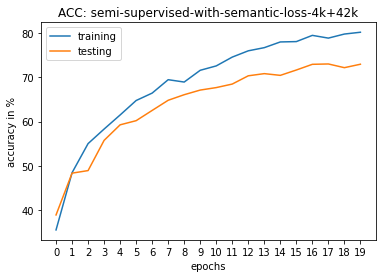

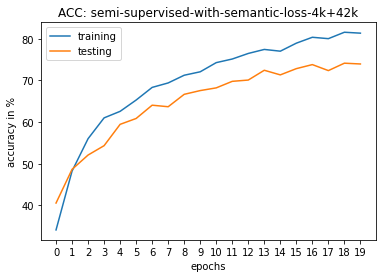

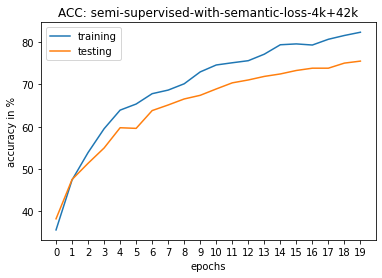

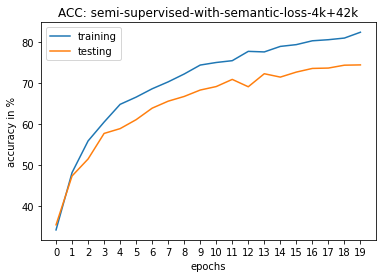

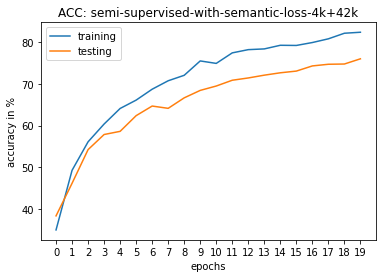

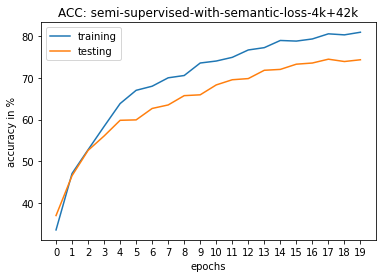

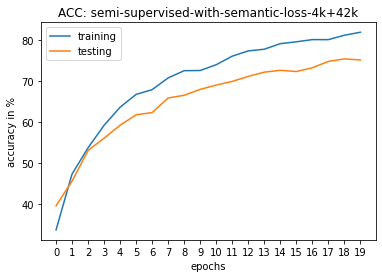

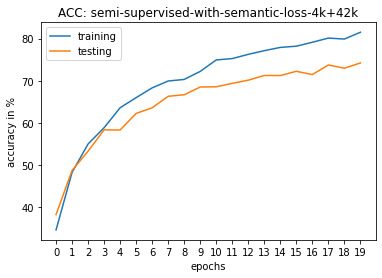

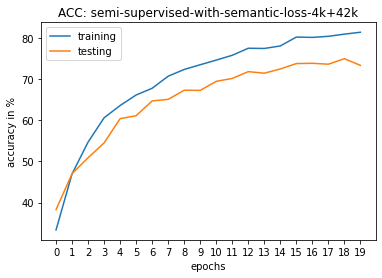

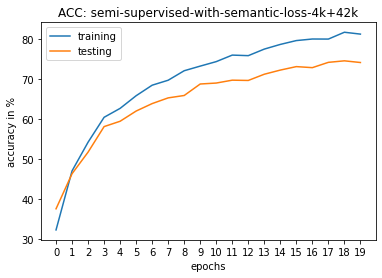

time: 2h 14min 58s (started: 2023-03-07 19:56:50 +00:00)


In [ ]:
# this accuracy is for reapeating same resampled image in dataset and dataloader, repeated indices_j
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    
    with open('./evaluation_task/vae_4k_resamples/test_acc.txt','a') as f:
        for key, value in all_testing_acc.items(): 
            f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    plt.figure()
    ax = plt.axes()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: semi-supervised-with-semantic-loss-4k+42k')
    ax.set_xticks(np.arange(max_epochs))
    plt.xlabel('epochs')
    plt.ylabel('accuracy in %')
    plt.legend()
    plt.savefig(f'./evaluation_task/vae_4k_resamples/new_run_{run}_for_all_epochs.png')

### pp

is 400 samples per class 4000


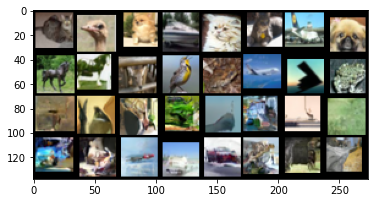

time: 31.4 s (started: 2023-03-08 13:29:30 +00:00)


In [11]:
# semi supervised: cifar + generated samples
# entire dataset of 95k

# right cifar10 data + applied trans_normalization + tensor images
t = transforms.Compose(
    [transforms.ToTensor()])
tt = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    # transforms.ToTensor()
    ])
xtrva_real1 = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=t)
real_labels = [y for _,y in xtrva_real1]
# s(xtrva_real[0][0])
# plt.show()
# loading biased samples
xtrva_gen1 = np.load('./resamples/resamples_pixelcnnpp_45k.npz')
xtrva_gen1 = torch.from_numpy(xtrva_gen1['resample'].astype('float64').transpose((0,3,1,2)))

class myEntireDataset(Dataset):
    #return tuples
    def __init__(self,xy_real, xy_gen):
        # xy_real = TensorDataset(xy_real, torch.tensor(real_labels) ) # tensor, dense labels, should not be a tuple, therefore processing outside the class
        xy_gen = TensorDataset(xy_gen, torch.full(([len(xy_gen)]),-1)) # tensor, tuples
        
        self.xy = ConcatDataset([xy_real, xy_gen])

        uniqe_labels = np.append(np.arange(10), -1)
        self.indices = [[] for _ in range(11)]
        for i, (img,label) in enumerate(self.xy):
            for label_ in uniqe_labels:
                if label == label_:
                    self.indices[label_].append(i) 

    def __len__(self):
        return len(self.xy)

    def classes(self):
        return self.indices

    def __getitem__(self, idx):
        x,y = self.xy[idx]
        x = tt(x)
        return x,y

class Sampler():
    # [[1,2,3],[50000,50001]]
    def __init__(self, classes, bs, n_labelled):
        self.classes = classes
        self.bs = bs
        self.n_labelled = n_labelled

    def __iter__(self):
        classes = copy.deepcopy(self.classes)
        # indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50000,50001,50002,50003,50004,50005,50006,50007,50008,50009,50010,50011,50012,50013,50014,50015,50016]
        # reandom class 1 [[29, 30, 35, 49, 77, 93, 115, 11],[]]
        # print(classes)
        indices = []
        # for i in range(11):
        #     indices.append(sample(train.classes()[i],10))


        labeled_data = classes[:-1]
        unlabeled_data = classes[-1]
        # # how many wants from each class
        indices_from_each_class = self.n_labelled // (len(classes)-1)
        final_data = []
        for i,eachClassLst in enumerate(labeled_data):
            final_data.append(random.sample(eachClassLst,indices_from_each_class))
      
        # flatten final data
        final_data = [item for sublist in final_data for item in sublist]
        print(f'is {indices_from_each_class} samples per class {len(final_data)}')
        # del final_data
        # print('total labeled data hould be 4k',len(final_data))
        ffinal_data = []
        h = int(0.5*self.bs)
        # iterations over one epoch
        for i in range(50000//self.bs):
            c = []
            c[:h] = random.sample(final_data,h)
            # print('first_half',c)
            # without replacements in each batch BUT with replacement across batches
            c[h:self.bs] = random.sample(unlabeled_data,h)
            ffinal_data.append(c)
            del c
                
        # print(ffinal_data)
        return iter(ffinal_data)


train123 = myEntireDataset(xtrva_real1, xtrva_gen1[:42000])
dl2 = torch.utils.data.DataLoader(train123, batch_sampler = Sampler(train123.classes(),32,4000))

# get some random training images
dataiter = iter(dl2)
images, labels = next(dataiter)
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


--------------------------------------------------------
-->starting experiment_1/10
---->staring epoch_1/20 epoch
is 400 samples per class 4000
 train_0 acc --> correct: 8047.0, total_labeled: 24992.0, Accuracy: 32.19830345710628 %
test_0 acc --> correct: 4036.0, total_labeled: 10000, Accuracy: 40.36%
---->staring epoch_2/20 epoch
is 400 samples per class 4000
 train_1 acc --> correct: 11529.0, total_labeled: 24992.0, Accuracy: 46.13076184379001 %
test_1 acc --> correct: 4864.0, total_labeled: 10000, Accuracy: 48.64%
---->staring epoch_3/20 epoch
is 400 samples per class 4000
 train_2 acc --> correct: 13592.0, total_labeled: 24992.0, Accuracy: 54.3854033290653 %
test_2 acc --> correct: 5392.0, total_labeled: 10000, Accuracy: 53.92%
---->staring epoch_4/20 epoch
is 400 samples per class 4000
 train_3 acc --> correct: 14888.0, total_labeled: 24992.0, Accuracy: 59.571062740076826 %
test_3 acc --> correct: 5924.0, total_labeled: 10000, Accuracy: 59.24%
---->staring epoch_5/20 epoch
is 400

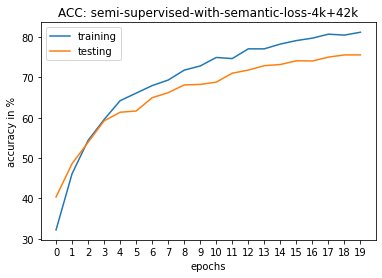

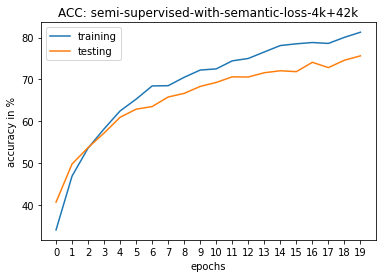

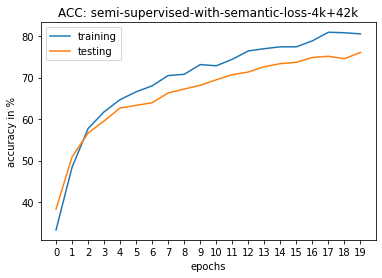

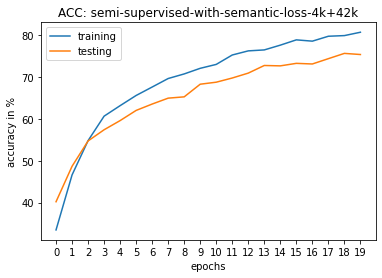

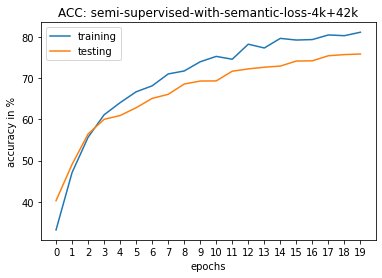

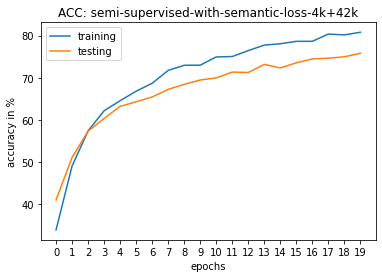

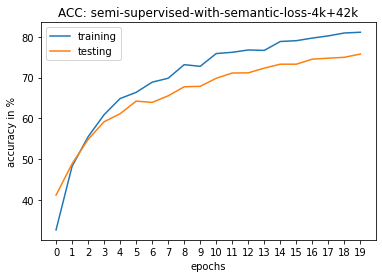

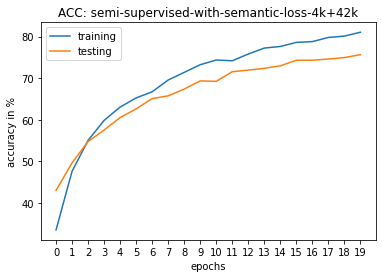

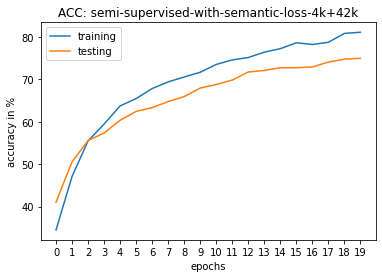

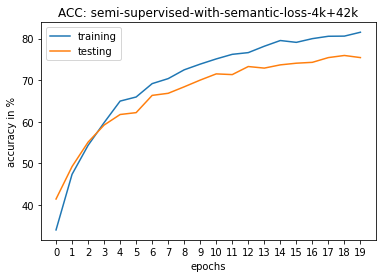

time: 2h 10min 44s (started: 2023-03-08 13:31:22 +00:00)


In [12]:
# this accuracy is for reapeating same resampled image in dataset and dataloader, repeated indices_j
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    
    with open('./evaluation_task/pixelcnnpp_4k_resamples_1/test_acc.txt','a') as f:
        for key, value in all_testing_acc.items(): 
            f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    plt.figure()
    ax = plt.axes()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: semi-supervised-with-semantic-loss-4k+42k')
    ax.set_xticks(np.arange(max_epochs))
    plt.xlabel('epochs')
    plt.ylabel('accuracy in %')
    plt.legend()
    plt.savefig(f'./evaluation_task/pixelcnnpp_4k_resamples_1/new_run_{run}_for_all_epochs.png')

### real 1k + resample 45k

#### vae

In [ ]:
# PixelCNNPP
############################
# generate 45k resamples 
!python sir.py --resample-j 45000
#############################
import pandas as pd
#wihtout random, shuffle=False
# give me the npz file 
data = np.load('./samples/pixelcnnpp/gen_samples.npz')['test_data']
indices_j = pd.read_csv('sir_indices_pixelcnnpp_resamples_45k.csv',header=None)

resampled_images_ar = data[indices_j[0]]

np.savez_compressed('./resamples/resamples_pixelcnnpp_45k.npz' , resample = resampled_images_ar)

###########################
# cross check model and their images from data, indices_j and npz file
plt.imshow(data[36714])
plt.imshow(np.load('./resamples/resamples_pixelcnnpp_45k.npz')['resample'][1])
###########################

In [ ]:
!pwd

/content
time: 116 ms (started: 2023-03-06 17:06:07 +00:00)


is 100 samples per class 1000


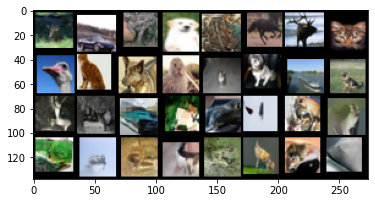

time: 25.6 s (started: 2023-03-06 20:10:05 +00:00)


In [ ]:
# semi supervised: cifar + generated samples
# entire dataset of 95k

# right cifar10 data + applied trans_normalization + tensor images
t = transforms.Compose(
    [transforms.ToTensor()])
tt = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    # transforms.ToTensor()
    ])
xtrva_real1 = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=t)
real_labels = [y for _,y in xtrva_real1]
# s(xtrva_real[0][0])
# plt.show()
# loading biased samples
xtrva_gen1 = np.load('./resamples/resamples_pixelcnnpp_45k.npz')
xtrva_gen1 = torch.from_numpy(xtrva_gen1['resample'].astype('float64').transpose((0,3,1,2)))

class myEntireDataset(Dataset):
    #return tuples
    def __init__(self,xy_real, xy_gen):
        # xy_real = TensorDataset(xy_real, torch.tensor(real_labels) ) # tensor, dense labels, should not be a tuple, therefore processing outside the class
        xy_gen = TensorDataset(xy_gen, torch.full(([len(xy_gen)]),-1)) # tensor, tuples
        
        self.xy = ConcatDataset([xy_real, xy_gen])

        uniqe_labels = np.append(np.arange(10), -1)
        self.indices = [[] for _ in range(11)]
        for i, (img,label) in enumerate(self.xy):
            for label_ in uniqe_labels:
                if label == label_:
                    self.indices[label_].append(i) 

    def __len__(self):
        return len(self.xy)

    def classes(self):
        return self.indices

    def __getitem__(self, idx):
        x,y = self.xy[idx]
        x = tt(x)
        return x,y

class Sampler():
    # [[1,2,3],[50000,50001]]
    def __init__(self, classes, bs, n_labelled):
        self.classes = classes
        self.bs = bs
        self.n_labelled = n_labelled

    def __iter__(self):
        classes = copy.deepcopy(self.classes)
        # indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50000,50001,50002,50003,50004,50005,50006,50007,50008,50009,50010,50011,50012,50013,50014,50015,50016]
        # reandom class 1 [[29, 30, 35, 49, 77, 93, 115, 11],[]]
        # print(classes)
        indices = []
        # for i in range(11):
        #     indices.append(sample(train.classes()[i],10))


        labeled_data = classes[:-1]
        unlabeled_data = classes[-1]
        # # how many wants from each class
        indices_from_each_class = self.n_labelled // (len(classes)-1)
        final_data = []
        for i,eachClassLst in enumerate(labeled_data):
            final_data.append(random.sample(eachClassLst,indices_from_each_class))

        # flatten final data
        final_data = [item for sublist in final_data for item in sublist]
        print(f'is {indices_from_each_class} samples per class {len(final_data)}')
        # del final_data

        ffinal_data = []
        h = int(0.5*self.bs)
        # iterations over one epoch
        for i in range(50000//self.bs):
            c = []
            c[:h] = random.sample(final_data,h)
            # print('first_half',c)
            # without replacements in each batch BUT with replacement across batches
            c[h:self.bs] = random.sample(unlabeled_data,h)
            ffinal_data.append(c)
            del c
                
        # print(ffinal_data)
        return iter(ffinal_data)


train123 = myEntireDataset(xtrva_real1, xtrva_gen1)
dl2 = torch.utils.data.DataLoader(train123, batch_sampler = Sampler(train123.classes(),32,1000))

# get some random training images
dataiter = iter(dl2)
images, labels = next(dataiter)
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


--------------------------------------------------------
-->starting experiment_1/10
---->staring epoch_1/20 epoch
is 100 samples per class 1000
 train_0 acc --> correct: 9170.0, total_labeled: 24992.0, Accuracy: 36.691741357234314 %
test_0 acc --> correct: 3929.0, total_labeled: 10000, Accuracy: 39.29%
---->staring epoch_2/20 epoch
is 100 samples per class 1000
 train_1 acc --> correct: 13588.0, total_labeled: 24992.0, Accuracy: 54.36939820742638 %
test_1 acc --> correct: 4572.0, total_labeled: 10000, Accuracy: 45.72%
---->staring epoch_3/20 epoch
is 100 samples per class 1000
 train_2 acc --> correct: 14857.0, total_labeled: 24992.0, Accuracy: 59.44702304737516 %
test_2 acc --> correct: 5105.0, total_labeled: 10000, Accuracy: 51.05%
---->staring epoch_4/20 epoch
is 100 samples per class 1000
 train_3 acc --> correct: 16930.0, total_labeled: 24992.0, Accuracy: 67.74167733674776 %
test_3 acc --> correct: 5383.0, total_labeled: 10000, Accuracy: 53.83%
---->staring epoch_5/20 epoch
is 10

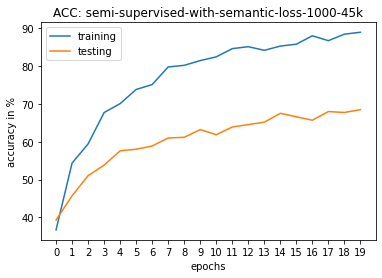

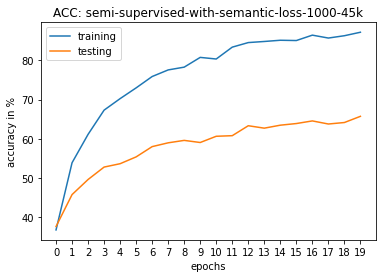

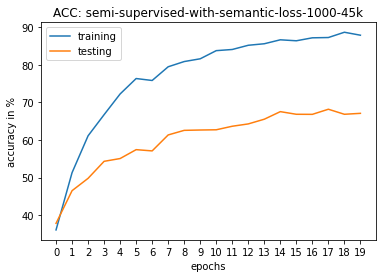

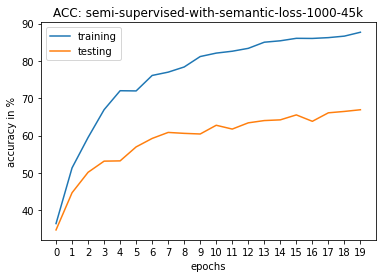

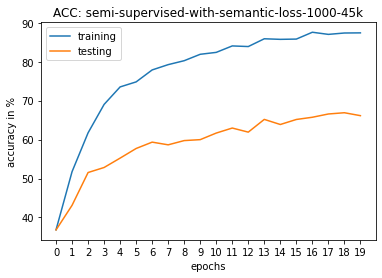

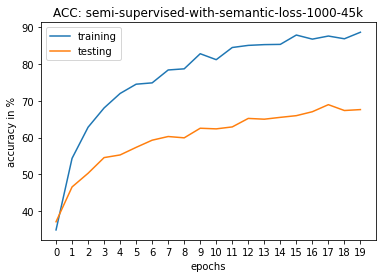

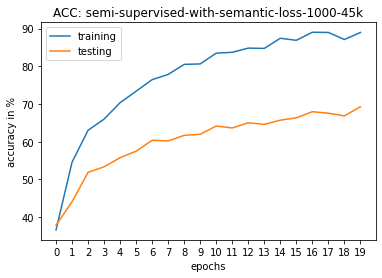

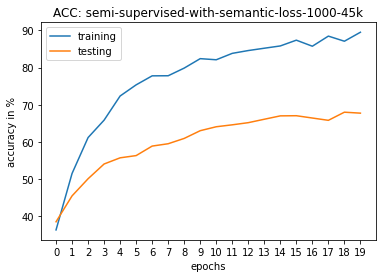

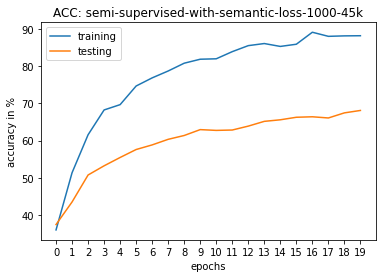

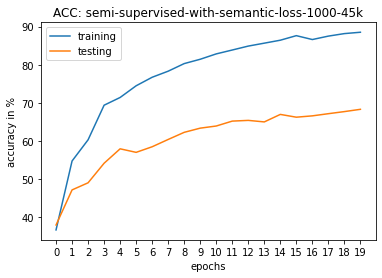

time: 2h 19min 25s (started: 2023-03-06 17:07:08 +00:00)


In [ ]:
# this accuracy is for reapeating same resampled image in dataset and dataloader, repeated indices_j
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    
    with open('./evaluation_task/vae_1k_resamples/test_acc.txt','a') as f:
        for key, value in all_testing_acc.items(): 
            f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    plt.figure()
    ax = plt.axes()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: semi-supervised-with-semantic-loss-1000-45k')
    ax.set_xticks(np.arange(max_epochs))
    plt.xlabel('epochs')
    plt.ylabel('accuracy in %')
    plt.legend()
    plt.savefig(f'./evaluation_task/vae_1k_resamples/new_run_{run}_for_all_epochs.png')

#### pp

--------------------------------------------------------
-->starting experiment_1/10
---->staring epoch_1/20 epoch
is 100 samples per class 1000
 train_0 acc --> correct: 8945.0, total_labeled: 24992.0, Accuracy: 35.791453265044815 %
test_0 acc --> correct: 4087.0, total_labeled: 10000, Accuracy: 40.87%
---->staring epoch_2/20 epoch
is 100 samples per class 1000
 train_1 acc --> correct: 13586.0, total_labeled: 24992.0, Accuracy: 54.361395646606915 %
test_1 acc --> correct: 4709.0, total_labeled: 10000, Accuracy: 47.09%
---->staring epoch_3/20 epoch
is 100 samples per class 1000
 train_2 acc --> correct: 14931.0, total_labeled: 24992.0, Accuracy: 59.74311779769526 %
test_2 acc --> correct: 5129.0, total_labeled: 10000, Accuracy: 51.29%
---->staring epoch_4/20 epoch
is 100 samples per class 1000
 train_3 acc --> correct: 16728.0, total_labeled: 24992.0, Accuracy: 66.93341869398208 %
test_3 acc --> correct: 5510.0, total_labeled: 10000, Accuracy: 55.1%
---->staring epoch_5/20 epoch
is 10

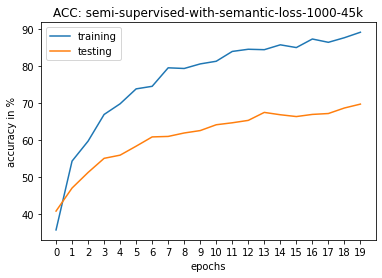

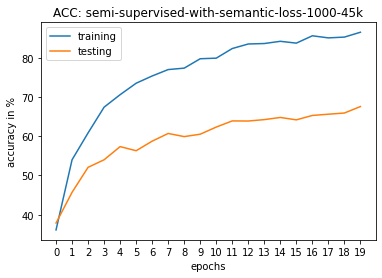

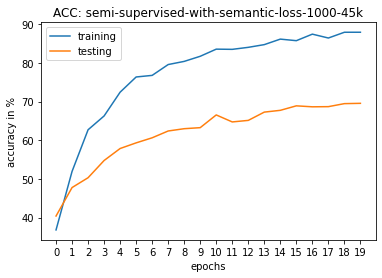

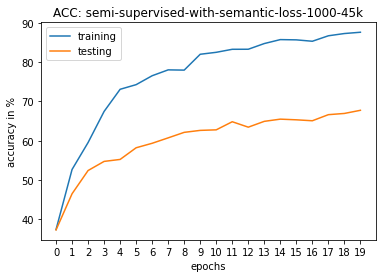

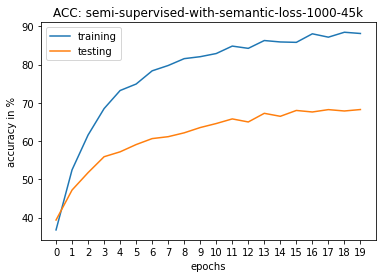

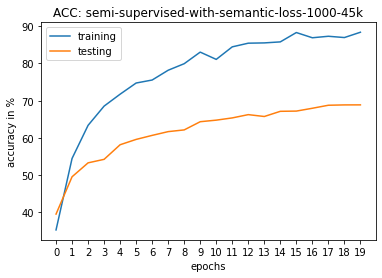

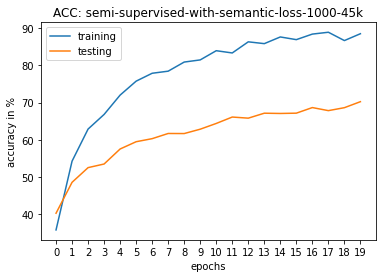

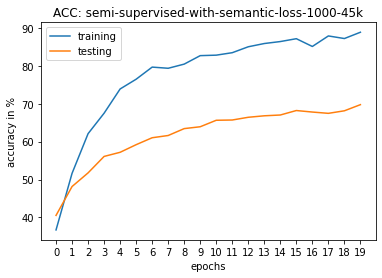

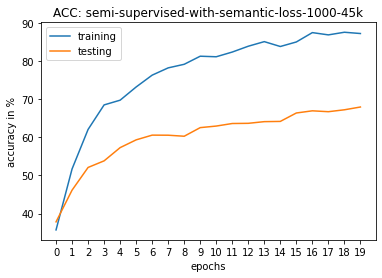

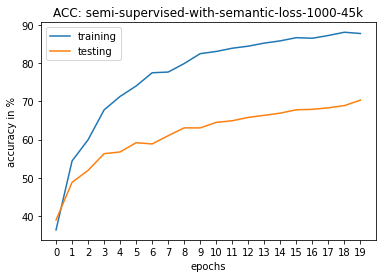

time: 2h 16min 42s (started: 2023-03-06 20:13:55 +00:00)


In [ ]:
# this accuracy is for reapeating same resampled image in dataset and dataloader, repeated indices_j
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    
    with open('./evaluation_task/pixelcnnpp_1k_resamples/test_acc.txt','a') as f:
        for key, value in all_testing_acc.items(): 
            f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    plt.figure()
    ax = plt.axes()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: semi-supervised-with-semantic-loss-1000-45k')
    ax.set_xticks(np.arange(max_epochs))
    plt.xlabel('epochs')
    plt.ylabel('accuracy in %')
    plt.legend()
    plt.savefig(f'./evaluation_task/pixelcnnpp_1k_resamples/new_run_{run}_for_all_epochs.png')

## Baseline

#### all labeled(50k) with semantic loss

In [ ]:
batch_size = 32
# same --> net, semantic_loss_fn, 
# 50k dataset

In [ ]:
trans = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
    ])

trainset = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=trans)
# trainloader sampler won't matter here as there is not labeled data 
# loos functuio is semantic loss function (not CEloss)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=8)


time: 13.1 s (started: 2023-03-06 22:54:37 +00:00)


In [ ]:
# balanced 46k indices, shuffle=true
uniqe_labels = np.arange(10)
indices = [[] for _ in range(10)]
for i, (img,label) in enumerate(trainset):
    for label_ in uniqe_labels:
        if label == label_:
            indices[label_].append(i)


def split_data(indices_lst=indices,n=100): #n=4600
    ind = []    
    for sublst in indices_lst:
        ind.append(sublst[:n])
    return ind

flattened_indices = [item for sublst in split_data() for item in sublst]

train = torch.utils.data.Subset(trainset, indices=flattened_indices)
dl2 = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=8,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=trans)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8,drop_last=True)

print('real train data size: ',len(train))
print('real test data size: ,',len(testset))

real train data size:  1000
real test data size: , 10000
time: 17.3 s (started: 2023-03-06 22:54:54 +00:00)


--------------------------------------------------------
-->starting experiment_1/10
---->staring epoch_1/20 epoch
 train_0 acc --> correct: 17390.0, total_labeled: 45984.0, Accuracy: 37.81750173973556 %
test_0 acc --> correct: 4576.0, total_labeled: 9984, Accuracy: 45.833333333333336%
---->staring epoch_2/20 epoch
 train_1 acc --> correct: 24669.0, total_labeled: 45984.0, Accuracy: 53.646920668058456 %
test_1 acc --> correct: 5641.0, total_labeled: 9984, Accuracy: 56.50040064102564%
---->staring epoch_3/20 epoch
 train_2 acc --> correct: 28039.0, total_labeled: 45984.0, Accuracy: 60.97555671537926 %
test_2 acc --> correct: 6229.0, total_labeled: 9984, Accuracy: 62.389823717948715%
---->staring epoch_4/20 epoch
 train_3 acc --> correct: 29950.0, total_labeled: 45984.0, Accuracy: 65.1313500347947 %
test_3 acc --> correct: 6597.0, total_labeled: 9984, Accuracy: 66.07572115384616%
---->staring epoch_5/20 epoch
 train_4 acc --> correct: 31567.0, total_labeled: 45984.0, Accuracy: 68.6477905

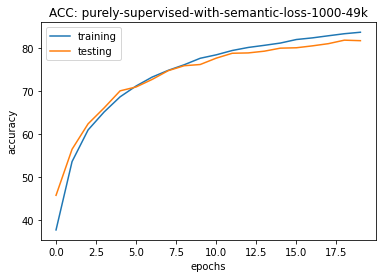

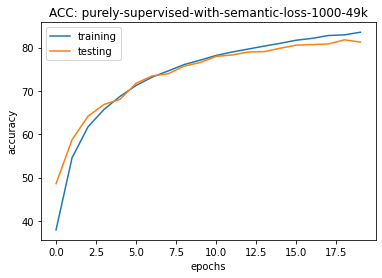

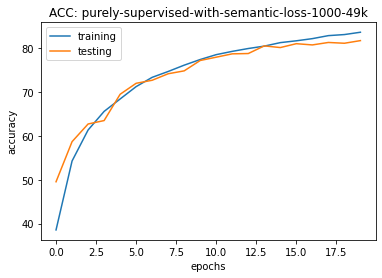

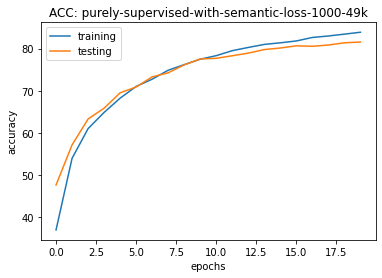

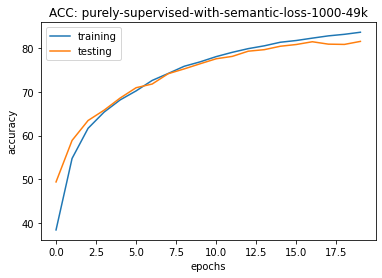

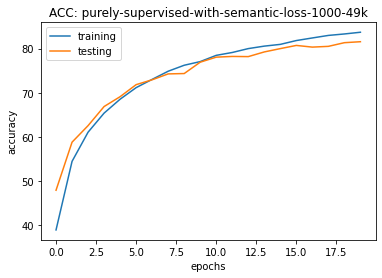

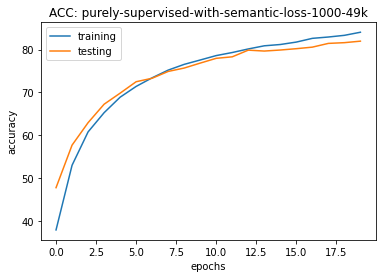

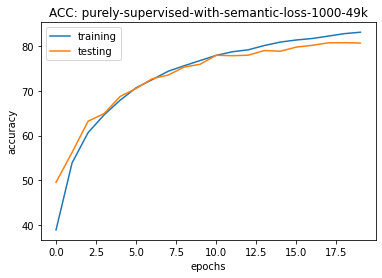

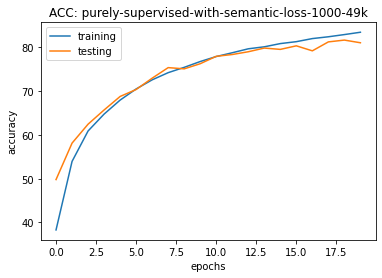

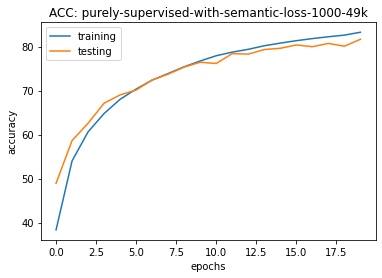

time: 1h 41min 42s (started: 2023-03-03 19:06:39 +00:00)


In [ ]:
#pixelcnn++ and VAE, 4600_each
max_epochs=20
runs = 10
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    with open('./evaluation_task/supervised/ALL_labeled_test_acc.txt','a') as f:
        for key, value in all_testing_acc.items(): 
            f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    plt.figure()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: purely-supervised-with-semantic-loss-1000-49k')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(f'./evaluation_task/supervised/new_run_{run}_for_all_epochs.png')

--------------------------------------------------------
-->starting experiment_1/1
---->staring epoch_1/20 epoch
 train_0 acc --> correct: 127.0, total_labeled: 992.0, Accuracy: 12.80241935483871 %
test_0 acc --> correct: 1670.0, total_labeled: 9984, Accuracy: 16.72676282051282%
---->staring epoch_2/20 epoch
 train_1 acc --> correct: 183.0, total_labeled: 992.0, Accuracy: 18.447580645161292 %
test_1 acc --> correct: 2113.0, total_labeled: 9984, Accuracy: 21.16386217948718%
---->staring epoch_3/20 epoch
 train_2 acc --> correct: 213.0, total_labeled: 992.0, Accuracy: 21.471774193548388 %
test_2 acc --> correct: 2308.0, total_labeled: 9984, Accuracy: 23.11698717948718%
---->staring epoch_4/20 epoch
 train_3 acc --> correct: 267.0, total_labeled: 992.0, Accuracy: 26.91532258064516 %
test_3 acc --> correct: 2559.0, total_labeled: 9984, Accuracy: 25.631009615384617%
---->staring epoch_5/20 epoch
 train_4 acc --> correct: 276.0, total_labeled: 992.0, Accuracy: 27.822580645161292 %
test_4 ac

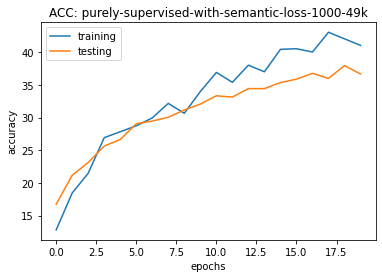

time: 1min 58s (started: 2023-03-06 23:03:40 +00:00)


In [ ]:
#pixelcnn++, 1000
max_epochs=20
runs = 1
all_training_acc = {}
all_testing_acc = {}
for run in range(runs):
    print('--------------------------------------------------------')
    epoch_training_acc = []
    epoch_testing_acc = []
    net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(f'-->starting experiment_{run+1}/{runs}')
    for epoch in range(max_epochs):  # loop over the dataset multiple times
        print(f'---->staring epoch_{epoch+1}/{max_epochs} epoch')
        correct = 0.0
        total = 0.0
        running_loss = 0.0
        each_iteration_max_acc = 0
        for i, data in enumerate(dl2, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # with torch.no_grad():
            #     labels[batch_size//2:] = -1
            # sparse labels
            oneHotLabels = one_hot_labels(labels).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.type(torch.FloatTensor).to(device)) # ([32,10])
            loss,label_eg = criterion(outputs, oneHotLabels)
            loss.backward()
            optimizer.step()
            # print statistics
            # running_loss += loss.item()
            # if i % 500 == 0:    # print every 500 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            #     running_loss = 0.0
            correct_preds = torch.eq(torch.argmax(outputs,1),torch.argmax(oneHotLabels,1)).to(device)
            correct_preds = torch.mul(correct_preds, label_eg)
            # print(f'the batch iteration_{i}: total_correct: {correct_preds.sum()} total_labeled: {label_eg.sum()}, acc:{correct_preds.sum()/label_eg.sum()} ')
            # acc = correct_preds.sum()/label_eg.sum()
            # if i % 1562:
            #     correct /= 1562
                # print(f'training acc per batch {i}',correct.item())
            correct += correct_preds.sum()
            total += label_eg.sum()
            if correct_preds.sum() > each_iteration_max_acc:
                each_iteration_max_acc = correct_preds.sum()
        
        print(f' train_{epoch} acc --> correct: {correct}, total_labeled: {total}, Accuracy: {100 * correct / total} %')
        epoch_training_acc.append(100 * correct.item() / total.item())
            # if i%1562==1561:
                # every second epoch what's the test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                test_images,test_labels = data
                test_onehot_labels = one_hot_labels(test_labels)
                test_outputs = net(test_images.to(device))
                test_correct_preds = torch.eq(torch.argmax(test_outputs,1),torch.argmax(test_onehot_labels.to(device),1)).type(torch.DoubleTensor)
                test_correct_preds = torch.mul(test_correct_preds, torch.ones([test_labels.shape[0],]))
                test_correct += test_correct_preds.sum()
                test_total += test_labels.shape[0]
        print(f'test_{epoch} acc --> correct: {test_correct}, total_labeled: {test_total}, Accuracy: {100*test_correct.item()/test_total}%')
        epoch_testing_acc.append(100*test_correct.item()/test_total)
        
        # print(f'{total},{correct}')
        
        # print(f'should be <= 16 {epoch}: {each_iteration_max_acc}')
    # print(epoch_training_acc, type(epoch_training_acc))
    # print(epoch_testing_acc, type(epoch_testing_acc))
    print(f'all epochs done for experiment_{run} and starting experiment_{run+1}')
    all_training_acc[f'training_acc_run_{run+1}'] = epoch_training_acc
    all_testing_acc[f'testing_acc_run_{run+1}'] = epoch_testing_acc
    # with open('./evaluation_task/supervised/ALL_labeled_test_acc.txt','a') as f:
    #     for key, value in all_testing_acc.items(): 
    #         f.write('%s:%s\n' % (key, value))
    print('Finished Training')
    # plt.figure()
    plt.plot(epoch_training_acc, label='training')
    plt.plot(epoch_testing_acc, label='testing')
    plt.title('ACC: purely-supervised-with-semantic-loss-1000-49k')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    # plt.savefig(f'./evaluation_task/supervised/new_run_{run}_for_all_epochs.png')